# VAE for ranking items

## Model Formalization

For each user $u \in U$, we have a set, $P_u$ = { $(m_1, m_2)$ | $rating_u^{m_1}$ > $rating_u^{m_2}$) } 

$P$ =  $\bigcup\limits_{\forall u \; \in \; U} P_u$

$\forall (u, m_1, m_2) \in P, $ we send two inputs, $x_1 = u \Vert m_1$ and $x_2 = u \Vert m_2$ to a VAE (with the same parameters).

We expect the VAE's encoder to produce $z_1$ (sampled from the distribution: $(\mu_1 , \Sigma_1$)) from $x_1$ ; and similarly $z_2$ from $x_2$ using the parameters $\theta$.

The decoder network is expected to learn a mapping function $f_{\phi}$ from $z_1$ to $m_1$.

We currently have 2 ideas for the decoder network:
1. Using two sets of network parameters, $\phi$ and $\psi$ for $z_1$ and $z_2$ respectively.
2. Using $\phi$ for both $z_1$ and $z_2$.

For ranking the pairs of movies, we have another network:
1. The input of the network is $z_1 \Vert z_2$, 
2. Is expected to learn a mapping, $f_{\delta}$ to a bernoulli distribution over True/False, modelling $rating_u^{m_1} > rating_u^{m_2}$.

## Loss Function

$$Loss \; = \; KL( \, \phi(z_1 \vert x_1) \Vert {\rm I\!N(0, I)} \, ) \; + \; KL( \, \psi(z_2 \vert x_2) \Vert {\rm I\!N(0, I)} \, ) \; - \; \sum_{i} m_{1i} \, log( \, f_{\phi}(z_1)_i ) \; - \; \sum_{i} m_{2i} \, log( \, f_{\psi}(z_2)_i ) \; - \; f_{\delta}(z_1 \Vert z_2) $$

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import gc
import time
import json
import pickle
import random
import functools
import numpy as np
import pandas as pd
from tqdm import tqdm
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Utlity functions

In [2]:
LongTensor = torch.LongTensor
FloatTensor = torch.FloatTensor

is_cuda_available = torch.cuda.is_available()

if is_cuda_available: 
    print("Using CUDA...\n")
    LongTensor = torch.cuda.LongTensor
    FloatTensor = torch.cuda.FloatTensor
    
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def save_obj_json(obj, name):
    with open(name + '.json', 'w') as f:
        json.dump(obj, f)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def load_obj_json(name):
    with open(name + '.json', 'r') as f:
        return json.load(f)

def file_write(log_file, s):
    print(s)
    f = open(log_file, 'a')
    f.write(s+'\n')
    f.close()

def clear_log_file(log_file):
    f = open(log_file, 'w')
    f.write('')
    f.close()

def pretty_print(h):
    print("{")
    for key in h:
        print(' ' * 4 + str(key) + ': ' + h[key])
    print('}\n')

Using CUDA...



# Hyper Parameters

In [3]:
hyper_params = {
    # 'data_base': 'saved_data/netflix/pro_sg/',
    # 'project_name': 'netflix_pytorch_netflix',
    # 'data_base': 'saved_data/pro_sg/',
    # 'project_name': 'netflix_pytorch_ml1m',
    # 'data_base': 'saved_data/netflix-full/pro_sg/',
    # 'project_name': 'netflix_pytorch_netflix_full',
    'data_base': '../saved_data/netflix-good-sample/pro_sg/',
    'project_name': 'netflix_pytorch_netflix_good_sample',
    'model_file_name': '',
    'log_file': '',
    'history_split_test': [0.8, 0.2], # Part of test history to train on : Part of test history to test

    'learning_rate': 0.01, # if optimizer is adadelta, learning rate is not required
    'optimizer': 'adam',
    'weight_decay': float(1e-2),

    'epochs': 50,
    'batch_size': 512,

    'hidden_size': 600,
    'latent_size': 200,

    'number_users_to_keep': 100000000000,
    'batch_log_interval': 100,
    'train_cp_users': 200,
}

file_name = '_optimizer_' + str(hyper_params['optimizer'])
if hyper_params['optimizer'] == 'adagrad':
    file_name += '_lr_' + str(hyper_params['learning_rate'])
file_name += '_weight_decay_' + str(hyper_params['weight_decay'])

hyper_params['log_file'] = '../saved_logs/' + hyper_params['project_name'] + '_log' + file_name + '.txt'
hyper_params['model_file_name'] = '../saved_models/' + hyper_params['project_name'] + '_model' + file_name + '.pt'


# Data Parsing

In [4]:
def load_data(hyper_params):
    
    file_write(hyper_params['log_file'], "Started reading data file")
    
    f = open(hyper_params['data_base'] + 'train.csv')
    lines_train = f.readlines()[1:]
    
    f = open(hyper_params['data_base'] + 'test_tr.csv')
    lines_test_tr = f.readlines()[1:]
    
    f = open(hyper_params['data_base'] + 'test_te.csv')
    lines_test_te = f.readlines()[1:]
    
    unique_sid = list()
    with open(hyper_params['data_base'] + 'unique_sid.txt', 'r') as f:
        for line in f:
            unique_sid.append(line.strip())
    num_items = len(unique_sid)
    
    file_write(hyper_params['log_file'], "Data Files loaded!")

    train_reader = DataReader(hyper_params, lines_train, None, num_items, True)
    test_reader = DataReader(hyper_params, lines_test_tr, lines_test_te, num_items, False)

    return train_reader, test_reader, num_items

class DataReader:

    def __init__(self, hyper_params, a, b, num_items, is_training):
        self.hyper_params = hyper_params
        self.batch_size = hyper_params['batch_size']
        
        num_users = 0
        min_user = 1000000000000000000000000
        for line in a:
            line = line.strip().split(",")
            num_users = max(num_users, int(line[0]))
            min_user = min(min_user, int(line[0]))
        num_users = num_users - min_user + 1
        
        self.num_users = num_users
        self.min_user = min_user
        self.num_items = num_items
        
        self.data_train = a
        self.data_test = b
        self.is_training = is_training
        self.all_users = []
        
        self.prep()
        self.number()

    def prep(self):
        self.data = []
        for i in range(self.num_users): self.data.append([])
            
        for i in tqdm(range(len(self.data_train))):
            line = self.data_train[i]
            line = line.strip().split(",")
            self.data[int(line[0]) - self.min_user].append(int(line[1]))
        
        if self.is_training == False:
            self.data_te = []
            for i in range(self.num_users): self.data_te.append([])
                
            for i in tqdm(range(len(self.data_test))):
                line = self.data_test[i]
                line = line.strip().split(",")
                self.data_te[int(line[0]) - self.min_user].append(int(line[1]))
        
    def number(self):
        self.num_b = int(min(len(self.data), self.hyper_params['number_users_to_keep']) / self.batch_size)
        
    def iter(self):
        users_done = 0

        x_batch = torch.zeros(self.batch_size, self.num_items).cuda()
        y_batch_s = torch.zeros(self.batch_size, self.num_items).cuda()
        #y_batch = []
        done_now = 0
        
        user_iterate_order = list(range(len(self.data)))
        np.random.shuffle(user_iterate_order)
        
        for user in user_iterate_order:

            if users_done > self.hyper_params['number_users_to_keep']: break
            users_done += 1
            
            # print(self.data[user])
            x_batch[done_now, :].scatter_(0, LongTensor(self.data[user]), 1.0)
            y_batch_s[done_now, :].scatter_(0, LongTensor(self.data[user]), 1.0)
            #y_batch.append([ i[0] for i in self.data[user] ])
            done_now += 1
    
            if done_now == self.batch_size:

                yield Variable(x_batch), Variable(y_batch_s, requires_grad=False)
                #yield Variable(x_batch), y_batch

                x_batch = torch.zeros(self.batch_size, self.num_items).cuda()
                y_batch_s = torch.zeros(self.batch_size, self.num_items).cuda()
                #y_batch = []
                done_now = 0

    def iter_eval(self):

        x_batch = torch.zeros(self.batch_size, self.num_items).cuda()
        y_batch_s = torch.zeros(self.batch_size, self.num_items).cuda()
        #y_batch = []
        test_movies, test_movies_r = [], []
        now_at = 0
        
        for user in range(len(self.data)):
            
            if self.is_training == True: 
                split = float(self.hyper_params['history_split_test'][0])
                base_predictions_on = self.data[user][:int(split * len(self.data[user]))]
                heldout_movies = self.data[user][int(split * len(self.data[user])):]
            else:
                base_predictions_on = self.data[user]
                heldout_movies = self.data_te[user]
                
            x_batch[now_at, :].scatter_(0, LongTensor([ i for i in base_predictions_on ]), 1.0)
            y_batch_s[now_at, :].scatter_(0, LongTensor([ i for i in base_predictions_on ]), 1.0)
            #y_batch.append([ i[0] for i in base_predictions_on ])
            now_at += 1
            
            test_movies.append([ i for i in heldout_movies ])
            test_movies_r.append([ 1 for i in heldout_movies ])
            
            if now_at == self.batch_size:
                
                yield Variable(x_batch), Variable(y_batch_s, requires_grad=False), \
                test_movies, test_movies_r
                #yield Variable(x_batch), y_batch, test_movies, test_movies_r
                
                x_batch = torch.zeros(self.batch_size, self.num_items).cuda()
                y_batch_s = torch.zeros(self.batch_size, self.num_items).cuda()
                #y_batch = []
                test_movies, test_movies_r = [], []
                now_at = 0

# Evaluation Code

In [5]:
def evaluate(model, criterion, reader, hyper_params, is_train_set):
    model.eval()

    metrics = {}
    metrics['loss'] = 0.0
    Ks = [10, 100]
    for k in Ks: 
        metrics['NDCG@' + str(k)] = 0.0
        metrics['HR@' + str(k)] = 0.0
        metrics['Prec@' + str(k)] = 0.0

    batch = 0
    total_ndcg = 0.0
    
    len_to_ndcg_at_100_map = {}

    for x, y, test_movies, test_movies_r in reader.iter_eval():
        batch += 1
        if is_train_set == True and batch > hyper_params['train_cp_users']: break

        decoder_output, z_mean, z_sigma = model(x)
        
        metrics['loss'] += criterion(decoder_output, z_mean, z_sigma, y, 0.2).data[0]
        
        # decoder_output[X.nonzero()] = -np.inf
        last_predictions = decoder_output - (torch.abs(decoder_output * x) * 100000000)
        
        for batch_num in range(last_predictions.shape[0]):
            predicted_scores = last_predictions[batch_num]
            actual_movies_watched = test_movies[batch_num]
            actual_movies_ratings = test_movies_r[batch_num]
                    
            # Calculate NDCG
            _, argsorted = torch.sort(-1.0 * predicted_scores)
            for k in Ks:
                best = 0.0
                now_at = 0.0
                dcg = 0.0
                hr = 0.0
                
                rec_list = list(argsorted[:k].data.cpu().numpy())
                for m in range(len(actual_movies_watched)):
                    movie = actual_movies_watched[m]
                    now_at += 1.0
                    if now_at <= k: best += 1.0 / float(np.log2(now_at + 1))
                    
                    if movie not in rec_list: continue
                    hr += 1.0
                    dcg += 1.0 / float(np.log2(float(rec_list.index(movie) + 2)))
                
                metrics['NDCG@' + str(k)] += float(dcg) / float(best)
                metrics['HR@' + str(k)] += float(hr) / float(len(actual_movies_watched))
                metrics['Prec@' + str(k)] += float(hr) / float(k)
                
                if k == 100:
                    seq_len = int(len(actual_movies_watched)) + int((x[batch_num].nonzero()).shape[0])
                    if seq_len not in len_to_ndcg_at_100_map: len_to_ndcg_at_100_map[seq_len] = []
                    len_to_ndcg_at_100_map[seq_len].append(float(dcg) / float(best))
                
            total_ndcg += 1.0
    
    metrics['loss'] = float(metrics['loss']) / float(batch)
    metrics['loss'] = round(metrics['loss'], 4)
    
    for k in Ks:
        metrics['NDCG@' + str(k)] = round((100.0 * metrics['NDCG@' + str(k)]) / float(total_ndcg), 4)
        metrics['HR@' + str(k)] = round((100.0 * metrics['HR@' + str(k)]) / float(total_ndcg), 4)
        metrics['Prec@' + str(k)] = round((100.0 * metrics['Prec@' + str(k)]) / float(total_ndcg), 4)

    return metrics, len_to_ndcg_at_100_map

# Model

In [6]:
class Encoder(nn.Module):
    def __init__(self, hyper_params):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(
            hyper_params['total_items'], hyper_params['hidden_size']
        )
        nn.init.xavier_normal(self.linear1.weight)
        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.linear1(x)
        # x = self.dropout(x)
        x = self.activation(x)
        return x

class Decoder(nn.Module):
    def __init__(self, hyper_params):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(hyper_params['latent_size'], hyper_params['hidden_size'])
        self.linear2 = nn.Linear(hyper_params['hidden_size'], hyper_params['total_items'])
        nn.init.xavier_normal(self.linear1.weight)
        nn.init.xavier_normal(self.linear2.weight)
        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.linear1(x)
#         x = self.dropout(x)
        x = self.activation(x)
        x = self.linear2(x)
#         x = self.dropout(x)
        return x
    
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

class Model(nn.Module):
    def __init__(self, hyper_params):
        super(Model, self).__init__()
        self.hyper_params = hyper_params
        
        self.encoder = Encoder(hyper_params)
        self.decoder = Decoder(hyper_params)
        
        self.layer_temp = nn.Linear(hyper_params['hidden_size'], 2*hyper_params['latent_size'])
        nn.init.xavier_normal(self.layer_temp.weight)
        
#         self._enc_mu = nn.Linear(hyper_params['hidden_size'], hyper_params['latent_size'])
#         self._enc_log_sigma = nn.Linear(hyper_params['hidden_size'], hyper_params['latent_size'])
#         nn.init.xavier_normal(self._enc_mu.weight)
#         nn.init.xavier_normal(self._enc_log_sigma.weight)
        
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.5)
        self.l2_norm = LayerNorm(hyper_params['total_items'])
#         self.l2_norm = nn.BatchNorm1d(hyper_params['total_items'])
        
    def sample_latent(self, h_enc):
        """
        Return the latent normal sample z ~ N(mu, sigma^2)
        """
#         mu = self._enc_mu(h_enc)
#         log_sigma = self._enc_log_sigma(h_enc)
        temp_out = self.layer_temp(h_enc)
        mu = temp_out[:, :self.hyper_params['latent_size']]
        log_sigma = temp_out[:, self.hyper_params['latent_size']:]
        sigma = torch.exp(log_sigma)
        std_z = torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float()
        if is_cuda_available: std_z = std_z.cuda()

        self.z_mean = mu
        self.z_sigma = log_sigma

        return mu + sigma * Variable(std_z, requires_grad=False)  # Reparameterization trick

    def forward(self, x):
        x = self.l2_norm(x)
        # x = self.dropout(x)
        h_enc = self.encoder(x)
        z = self.sample_latent(h_enc)
        dec = self.decoder(z)
                              
        return dec, self.z_mean, self.z_sigma

# Custom loss

In [7]:
class VAELoss(torch.nn.Module):
    def __init__(self, hyper_params):
        super(VAELoss,self).__init__()
        self.cce = nn.CrossEntropyLoss(size_average=True)

    def forward(self, decoder_output, mu_q, logvar_q, y_true_s, anneal):
        
#         mean_sq = mu_q * mu_q
#         stddev_sq = std_q * std_q
#         std_q = tf.exp(0.5 * logvar_q)
#         print(mean_sq.shape)
#         print(stddev_sq.shape)
#         kld = torch.mean(mean_sq + stddev_sq - torch.log(stddev_sq) - 1)
        
        kld = torch.mean(torch.sum(0.5 * (-logvar_q + torch.exp(logvar_q) + mu_q**2 - 1), -1))
    
#         likelihood = None
#         print(torch.sum(decoder_output[0]))
#         decoder_output = F.softmax(decoder_output, -1)
#         print(torch.sum(decoder_output[0]))
#         for b in range(len(y_true_s)):
#             for i in y_true_s[b]:
#                 if likelihood is None: likelihood = -1.0 * torch.log(decoder_output[b, i])
#                 else: likelihood = likelihood - torch.log(decoder_output[b, i])
#         likelihood = likelihood / float(len(y_true_s))
    
        decoder_output = F.log_softmax(decoder_output, -1)
        temp = y_true_s * decoder_output
        likelihood = torch.mean(-torch.sum(temp, -1))
        
        final = (anneal * kld) + (1.0 * likelihood)
        
        return final

# Training loop

Started reading data file
Data Files loaded!


100%|██████████| 304605/304605 [00:00<00:00, 1026042.01it/s]




Simulation run on: 2018-10-15 07:18:42.499177


Data reading complete!
Number of train batches:  116
Number of test batches:   15
Total Items: 17647

Model(
  (encoder): Encoder(
    (linear1): Linear(in_features=17647, out_features=600, bias=True)
    (activation): Tanh()
    (dropout): Dropout(p=0.5)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=200, out_features=600, bias=True)
    (linear2): Linear(in_features=600, out_features=17647, bias=True)
    (activation): Tanh()
    (dropout): Dropout(p=0.5)
  )
  (layer_temp): Linear(in_features=600, out_features=400, bias=True)
  (tanh): Tanh()
  (dropout): Dropout(p=0.5)
  (l2_norm): LayerNorm(
  )
)

Model Built!
Starting Training...

| epoch   1 |   100/  116 batches | ms/batch 100.73 | loss 1517.3509
| epoch   1 |   116/  116 batches | ms/batch 106.14 | loss 1544.2279
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 86.57s | loss = 1235.3179 | NDCG@10 

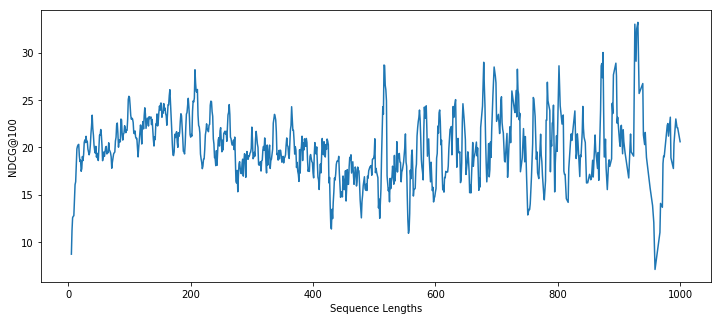

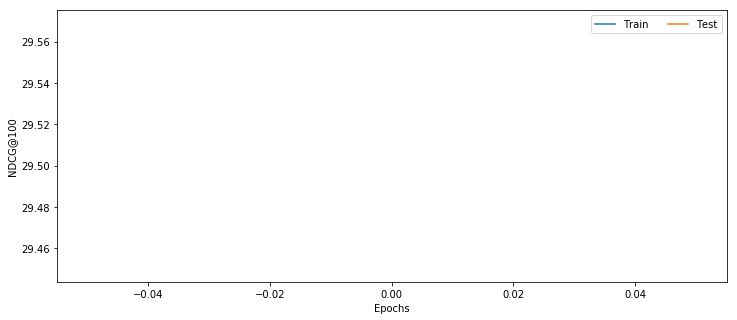

In [8]:
def train(reader):
    model.train()
    total_loss = 0
    start_time = time.time()
    batch = 0
    batch_limit = int(train_reader.num_b)
    total_anneal_steps = 200000
    anneal = 0.0
    update_count = 0.0
    anneal_cap = 0.2

    for x, y in reader.iter():
        # print(x[0])
        batch += 1
        
        model.zero_grad()
        optimizer.zero_grad()

        decoder_output, z_mean, z_sigma = model(x)
        
        loss = criterion(decoder_output, z_mean, z_sigma, y, anneal)
        loss.backward()

        optimizer.step()

        total_loss += loss.data
        
        if total_anneal_steps > 0:
            anneal = min(anneal_cap, 1. * update_count / total_anneal_steps)
        else:
            anneal = anneal_cap
        update_count += 1.0

        if (batch % hyper_params['batch_log_interval'] == 0 and batch > 0) or batch == batch_limit:
            div = hyper_params['batch_log_interval']
            if batch == batch_limit: div = (batch_limit % hyper_params['batch_log_interval']) - 1
            if div <= 0: div = 1

            cur_loss = (total_loss[0] / div)
            elapsed = time.time() - start_time
            
            ss = '| epoch {:3d} | {:5d}/{:5d} batches | ms/batch {:5.2f} | loss {:5.4f}'.format(
                    epoch, batch, batch_limit, (elapsed * 1000) / div, cur_loss
            )
            
            file_write(hyper_params['log_file'], ss)

            total_loss = 0
            start_time = time.time()

train_reader, test_reader, total_items = load_data(hyper_params)
# print(train_reader.data[:10])
# print(test_reader.data[:10])
# print(test_reader.data_te[:10])
hyper_params['total_items'] = total_items
hyper_params['testing_batch_limit'] = test_reader.num_b

file_write(hyper_params['log_file'], "\n\nSimulation run on: " + str(dt.datetime.now()) + "\n\n")
file_write(hyper_params['log_file'], "Data reading complete!")
file_write(hyper_params['log_file'], "Number of train batches: {:4d}".format(train_reader.num_b))
file_write(hyper_params['log_file'], "Number of test batches: {:4d}".format(test_reader.num_b))
# file_write(hyper_params['log_file'], "Total Users: " + str(total_users))
file_write(hyper_params['log_file'], "Total Items: " + str(total_items) + "\n")

model = Model(hyper_params)
if is_cuda_available: model.cuda()

criterion = VAELoss(hyper_params)

if hyper_params['optimizer'] == 'adagrad':
    optimizer = torch.optim.Adagrad(
        model.parameters(), weight_decay=hyper_params['weight_decay'], lr=hyper_params['learning_rate']
    )
elif hyper_params['optimizer'] == 'adadelta':
    optimizer = torch.optim.Adadelta(
        model.parameters(), weight_decay=hyper_params['weight_decay']
    )
elif hyper_params['optimizer'] == 'adam':
    optimizer = torch.optim.Adam(
        model.parameters(), weight_decay=hyper_params['weight_decay']#, lr=hyper_params['learning_rate']
    )
elif hyper_params['optimizer'] == 'rmsprop':
    optimizer = torch.optim.RMSprop(
        model.parameters(), weight_decay=hyper_params['weight_decay']#, lr=hyper_params['learning_rate']
    )

file_write(hyper_params['log_file'], str(model))
file_write(hyper_params['log_file'], "\nModel Built!\nStarting Training...\n")

best_val_loss = None

try:
    for epoch in range(1, hyper_params['epochs'] + 1):
        epoch_start_time = time.time()
        
        train(train_reader)
        
        # Calulating the metrics on the train set
        metrics, _ = evaluate(model, criterion, train_reader, hyper_params, True)
        string = ""
        for m in metrics: string += " | " + m + ' = ' + str(metrics[m])
        string += ' (TRAIN)'
    
        # Calulating the metrics on the test set
        metrics, len_to_ndcg_at_100_map = evaluate(model, criterion, test_reader, hyper_params, False)
        string2 = ""
        for m in metrics: string2 += " | " + m + ' = ' + str(metrics[m])
        string2 += ' (TEST)'

        ss  = '-' * 89
        ss += '\n| end of epoch {:3d} | time: {:5.2f}s'.format(epoch, (time.time() - epoch_start_time))
        ss += string
        ss += '\n'
        ss += '-' * 89
        ss += '\n| end of epoch {:3d} | time: {:5.2f}s'.format(epoch, (time.time() - epoch_start_time))
        ss += string2
        ss += '\n'
        ss += '-' * 89
        file_write(hyper_params['log_file'], ss)
        
        if not best_val_loss or metrics['loss'] <= best_val_loss:
            with open(hyper_params['model_file_name'], 'wb') as f: torch.save(model, f)
            best_val_loss = metrics['loss']
        
        # Plot sequence length vs NDCG@100 graph
        # plot_len_vs_ndcg(len_to_ndcg_at_100_map)

#         lens = list(len_to_ndcg_at_100_map.keys())
#         lens.sort()
#         X = []
#         Y = []
#         for le in lens:
#             X.append(le)
#             ans = 0.0
#             for i in len_to_ndcg_at_100_map[le]: ans += float(i)
#             ans = ans / float(len(len_to_ndcg_at_100_map[le]))
#             Y.append(ans * 100.0)
#         Y_mine = []
#         prev_5 = []
#         for i in Y:
#             prev_5.append(i)
#             if len(prev_5) > 5: del prev_5[0]

#             temp = 0.0
#             for j in prev_5: temp += float(j)
#             temp = float(temp) / float(len(prev_5))
#             Y_mine.append(temp)
#         plt.figure(figsize=(12, 5))
#         print(X)
#         print(Y_mine)
#         plt.plot(X, Y_mine)
#         plt.xlabel("Sequence Lengths")
#         plt.ylabel("NDCG@100")
#         plt.show()

except KeyboardInterrupt: print('Exiting from training early')

# Checking metrics on best saved model
with open(hyper_params['model_file_name'], 'rb') as f: model = torch.load(f)
metrics, len_to_ndcg_at_100_map = evaluate(model, criterion, test_reader, hyper_params, False)

string = ""
for m in metrics: string += " | " + m + ' = ' + str(metrics[m])

ss  = '=' * 89
ss += '\n| End of training'
ss += string
ss += '\n'
ss += '=' * 89
file_write(hyper_params['log_file'], ss)

# Plot sequence length vs NDCG@100 graph
# plot_len_vs_ndcg(len_to_ndcg_at_100_map)
lens = list(len_to_ndcg_at_100_map.keys())
lens.sort()
X = []
Y = []
for le in lens:
    X.append(le)
    ans = 0.0
    for i in len_to_ndcg_at_100_map[le]: ans += float(i)
    ans = ans / float(len(len_to_ndcg_at_100_map[le]))
    Y.append(ans * 100.0)
Y_mine = []
prev_5 = []
for i in Y:
    prev_5.append(i)
    if len(prev_5) > 5: del prev_5[0]

    temp = 0.0
    for j in prev_5: temp += float(j)
    temp = float(temp) / float(len(prev_5))
    Y_mine.append(temp)
plt.figure(figsize=(12, 5))
# print(X)
# print(Y_mine)
plt.plot(X, Y_mine)
plt.xlabel("Sequence Lengths")
plt.ylabel("NDCG@100")
pass

# Plot Traning graph
f = open(model.hyper_params['log_file'])
lines = f.readlines()
lines.reverse()

train = []
test = []

for line in lines:
    if line[:10] == 'Simulation' and len(train) > 0: break
    if line[2:5] == 'end' and line[-6:-2] == 'TEST': test.append(line.strip().split("|"))
    elif line[2:5] == 'end' and line[-7:-2] == 'TRAIN': train.append(line.strip().split("|"))

train.reverse()
test.reverse()

train_cp, train_ndcg = [], []
test_cp, test_ndcg = [], []

for i in train:
    train_cp.append(float(i[3].split('=')[1].strip(' ')))
    train_ndcg.append(float(i[-2].split('=')[1].split(' ')[1]))
    
for i in test:
    test_cp.append(float(i[3].split('=')[1].strip(' ')))
    test_ndcg.append(float(i[-2].split('=')[1].split(' ')[1]))

plt.figure(figsize=(12, 5))
plt.plot(train_ndcg, label='Train')
plt.plot(test_ndcg, label='Test')
plt.ylabel("NDCG@100")
plt.xlabel("Epochs")

leg = plt.legend(loc='best', ncol=2)
pass